# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [50]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Esophagus'

## QC Settings

In [51]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = True  # True or False; select only highly variable features

# Highly Variable Features thresholds:
min_limit = 1000
max_limit = 5000

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Filter to use:
n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
filter_pct_fp= True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_n_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_chrM_fragments= True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_uniquely_mapped_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined


# if this is True thresholds below are ignored 
only_automatic_thresholds = True # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 5
max_features = 10000

# default mean_insertsize
upper_threshold_mis=160 
lower_threshold_mis=80

# default promotor enrichment
upper_threshold_pct_fp=0.4
lower_threshold_pct_fp=0.1

# default number of fragments
upper_thr_fragments=200000
lower_thr_fragments=0

# default number of fragments in chrM
upper_thr_chrM_fragments=10000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [52]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [53]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [54]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [55]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

In [56]:
adata.var 

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
name,,,,,,
b'chr1':10008-10690,411,0.005825,0.005808,99.44197,429.0,6.063785
b'chr1':11179-11381,0,0.000000,0.000000,100.00000,0.0,0.000000
b'chr1':28734-29439,22,0.000299,0.000299,99.97013,22.0,3.135494
b'chr1':29495-29682,0,0.000000,0.000000,100.00000,0.0,0.000000
b'chr1':34673-35029,0,0.000000,0.000000,100.00000,0.0,0.000000
...,...,...,...,...,...,...
b'chrY':57203305-57203488,0,0.000000,0.000000,100.00000,0.0,0.000000
b'chrY':57206427-57206551,0,0.000000,0.000000,100.00000,0.0,0.000000
b'chrY':57215321-57215411,0,0.000000,0.000000,100.00000,0.0,0.000000


<AxesSubplot:xlabel='Insertsize (bp)', ylabel='Count'>

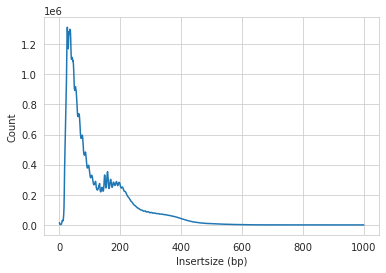

In [57]:
atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [58]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [59]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [60]:
display(adata)

View of AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 2. removing empty cells and features

In [61]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=15)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 71726 × 144819
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 3. binarize

In [62]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

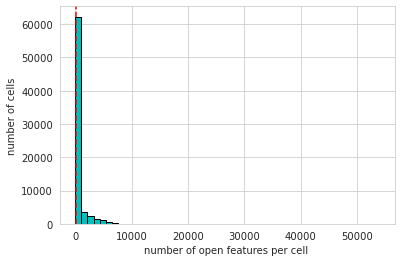

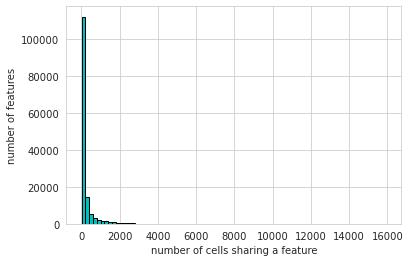

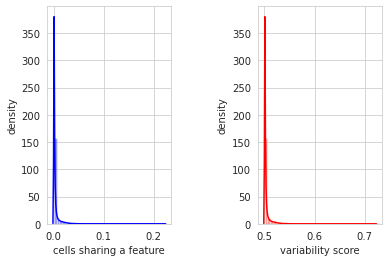

In [63]:
plot_ov_hist(adata, threshold_features=50) # FIXME: Later plots do not visualize

## 6. filter cells

### 6.1 get thresholds dict

In [64]:
groupby = condition_column if global_threshold is False else None
default_thresholds = build_default_thresholds(adata, manual_thresholds, groupby)
default_thresholds

{'n_features_by_counts': {'min': 5, 'max': 10000},
 'mean_insertsize': {'min': 80, 'max': 160},
 'pct_fragments_in_promoters': {'min': 0.1, 'max': 0.4},
 'CM': {'min': 0, 'max': 10000}}

In [65]:
thresholds = get_thresholds_atac_wrapper(adata, default_thresholds, only_automatic_thresholds, groupby=None)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,n_features_by_counts,-5.261403,17.774501
1,mean_insertsize,67.538022,196.514123
2,pct_fragments_in_promoters,-0.434211,0.849552
3,CM,-1.382675,2.053520


### 6.2 plot thresholds

In [66]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = quality_violin(adata, columns=obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=tree.qc_plots + "cell_filtering.png")
obs_figure

In [70]:
# Get final thresholds
final_thresholds = get_slider_thresholds(obs_slider_dict)
thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Minimum,Maximum
0,n_features_by_counts,17.800000,40375.300000
1,mean_insertsize,67.538022,196.514123
2,pct_fragments_in_promoters,0.000000,0.849552
3,CM,0.000000,6604.700000


### 6.3 filter adata

In [71]:
apply_qc_thresholds(adata, final_thresholds)

Filtering based on 'n_features_by_counts' from 63055 -> 15166 cells
Filtering based on 'mean_insertsize' from 15166 -> 15166 cells
Filtering based on 'pct_fragments_in_promoters' from 15166 -> 15166 cells
Filtering based on 'CM' from 15166 -> 15166 cells


### remove empty features

In [73]:
epi.pp.filter_features(adata, min_cells=15)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 15166 × 144751
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## 7. save plots

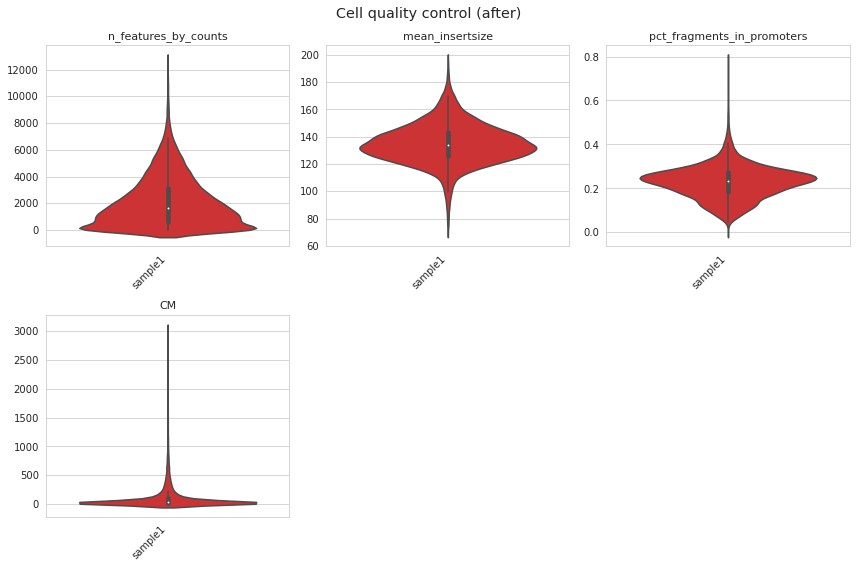

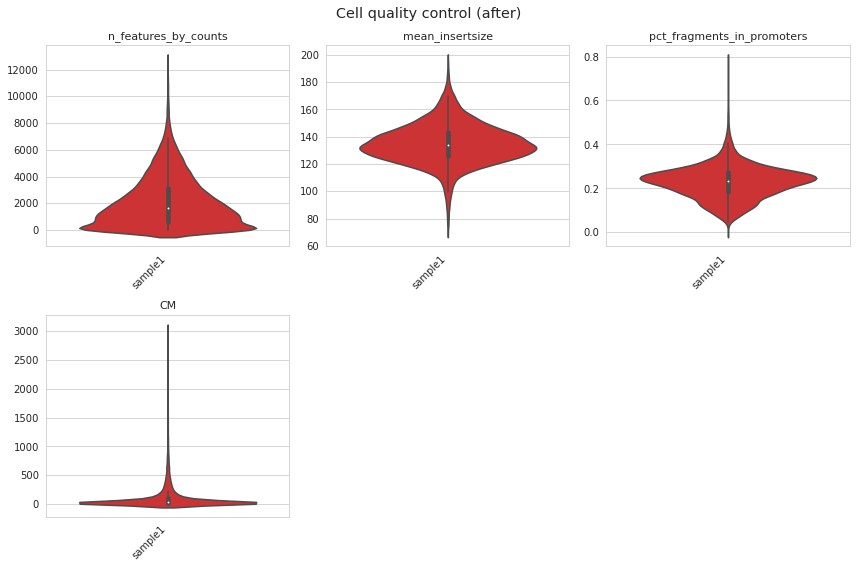

In [74]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save anndata

In [75]:
adata.obs

,TN,UM,PP,UQ,CM,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize,n_total_fragments,n_fragments_in_promoters,pct_fragments_in_promoters,nb_features,log_nb_features
barcode,,,,,,,,,,,,,,,,,,
AAACTACCAGAAACGTCCCGTT,6223.0,5232.0,5214.0,3780.0,18.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,1596,7.375882,1733.0,7.458186,4923.0,137.92,5210.0,1256.0,0.241075,1595.0,3.202761
AAACTACCAGAACGACTGCTCG,18671.0,16815.0,16781.0,11802.0,131.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,6881,8.836665,7937.0,8.979417,16343.0,128.82,16169.0,4326.0,0.267549,6881.0,3.837652
AAACTACCAGAACTAACGTCGA,8196.0,6756.0,6737.0,4617.0,382.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,304,5.720312,492.0,6.200509,6729.0,141.34,6864.0,1095.0,0.159528,303.0,2.481443
AAACTACCAGAAGCCCATTGCC,79.0,71.0,71.0,67.0,1.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,32,3.496508,32.0,3.496508,51.0,105.24,39.0,6.0,0.153846,32.0,1.505150
AAACTACCAGAAGCGCCATCGA,25061.0,22370.0,22321.0,15169.0,316.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,6460,8.773539,7791.0,8.960853,21691.0,117.78,22223.0,5079.0,0.228547,6457.0,3.810031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTCTCATGGTCA,5447.0,4744.0,4728.0,3243.0,10.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,1696,7.436617,1826.0,7.510430,4810.0,142.30,4560.0,1396.0,0.306140,1695.0,3.229170
TTCCATCCTCTTGACAAGTCCT,1577.0,1342.0,1337.0,909.0,1.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,332,5.808142,360.0,5.888878,1327.0,139.90,1345.0,350.0,0.260223,332.0,2.521138
TTCCATCCTCTTGAGCCCGGAT,9935.0,7985.0,7957.0,5603.0,13.0,/home/rstudio/data/anndata/Esophagus.h5ad,sample1,636,6.456770,677.0,6.519147,7769.0,159.39,7717.0,712.0,0.092264,635.0,2.802774


In [76]:
adata.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score
name,,,,,,,,,,
b'chr1':10008-10690,411,0.005825,0.005808,99.441970,429.0,6.063785,405,411.0,0.005730,0.505730
b'chr1':28734-29439,22,0.000299,0.000299,99.970130,22.0,3.135494,22,22.0,0.000307,0.500307
b'chr1':180715-182001,566,0.008472,0.008437,99.231521,624.0,6.437752,560,566.0,0.007891,0.507891
b'chr1':267912-268112,84,0.001154,0.001153,99.885950,85.0,4.454347,82,84.0,0.001171,0.501171
b'chr1':586083-586296,43,0.000625,0.000624,99.941617,46.0,3.850148,43,43.0,0.000600,0.500600
...,...,...,...,...,...,...,...,...,...,...
b'chrY':56850341-56850512,168,0.002430,0.002427,99.771900,179.0,5.192957,165,168.0,0.002342,0.502342
b'chrY':56850727-56850991,317,0.004969,0.004957,99.569598,366.0,5.905362,311,317.0,0.004420,0.504420
b'chrY':56851054-56851184,113,0.001643,0.001642,99.846576,121.0,4.804021,110,113.0,0.001575,0.501575


In [77]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)